In [1]:
import numpy as np
import os
import xraydb
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from scipy.optimize import curve_fit
import glob
import re
import pathlib
from tqdm.auto import tqdm
import numpy as np
import dask.array as da
from scipy.spatial.distance import pdist, squareform
import xraydb
from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor, as_completed
import numexpr as ne

In [2]:
%matplotlib inline
ptable = {
    'H': 1, 'He': 2,
    'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42, 
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 
    'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66,
    'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 
    'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82,
    'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92
}

atomic_masses = {
    'H': 1.0, 'He': 4.0, 'Li': 6.9, 'Be': 9.0, 'B': 10.8, 'C': 12.0, 'N': 14.0, 'O': 16.0,
    'F': 19.0, 'Ne': 20.2, 'Na': 22.9, 'Mg': 24.3, 'Al': 26.9, 'Si': 28.1, 'P': 30.9, 'S': 32.1,
    'Cl': 35.4, 'Ar': 39.9, 'K': 39.1, 'Ca': 40.1, 'Sc': 44.9, 'Ti': 47.9, 'V': 50.9, 'Cr': 52.0,
    'Mn': 54.9, 'Fe': 55.8, 'Co': 58.9, 'Ni': 58.7, 'Cu': 63.5, 'Zn': 65.4, 'Ga': 69.7, 'Ge': 72.6,
    'As': 74.9, 'Se': 79.0, 'Br': 79.9, 'Kr': 83.8, 'Rb': 85.5, 'Sr': 87.6, 'Y': 88.9, 'Zr': 91.2,
    'Nb': 92.9, 'Mo': 95.9, 'Tc': 98.0, 'Ru': 101.1, 'Rh': 102.9, 'Pd': 106.4, 'Ag': 107.9, 'Cd': 112.4,
    'In': 114.8, 'Sn': 118.7, 'Sb': 121.8, 'Te': 127.6, 'I': 126.9, 'Xe': 131.3, 'Cs': 132.9, 'Ba': 137.3,
    'La': 138.9, 'Ce': 140.1, 'Pr': 140.9, 'Nd': 144.2, 'Pm': 145.0, 'Sm': 150.4, 'Eu': 152.0, 'Gd': 157.3,
    'Tb': 158.9, 'Dy': 162.5, 'Ho': 164.9, 'Er': 167.3, 'Tm': 168.9, 'Yb': 173.0, 'Lu': 175.0, 'Hf': 178.5,
    'Ta': 180.9, 'W': 183.8, 'Re': 186.2, 'Os': 190.2, 'Ir': 192.2, 'Pt': 195.1, 'Au': 197.0, 'Hg': 200.6,
    'Tl': 204.4, 'Pb': 207.2, 'Bi': 208.9, 'Po': 209.0, 'At': 210.0, 'Rn': 222.0, 'Fr': 223.0, 'Ra': 226.0,
    'Ac': 227.0, 'Th': 232.0, 'Pa': 231.0, 'U': 238.0
}

In [3]:
def compute_sq_for_q(q_val, rij_matrix, f0_q_elements):
    f0_q = f0_q_elements[:, q_val[1]]  # Atomic scattering factors for this q value
    rij_q = rij_matrix * q_val[0]  # Pre-multiply rij by q_val to avoid repetitive computation
    sinc_rij_q = np.sinc(rij_q / np.pi)  # np.sinc includes division by pi
    return np.sum(np.outer(f0_q, f0_q) * sinc_rij_q)

def sq_with_f0_thread(pos, elements, f0_scales, qs):
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    f0_q_elements *= f0_scales[:, np.newaxis]

    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers to your environment
        futures = {executor.submit(compute_sq_for_q, (q_val, i), rij_matrix, f0_q_elements): i for i, q_val in enumerate(qs)}
        for future in tqdm(as_completed(futures), total=len(futures)):
            sq[futures[future]] = future.result()

    return sq

def sq_with_f0(pos, elements, f0_scales, qs):
    '''
    Calculates the scattering profile using the debye equation with atomic scattering factors.

    Input
      pos = scatterer positions in 3D cartesian coordinates (nx3 array)
      elements = 1D array of string of the element symbols for each scatterer
      f0_scales = 1D array of scaling factors for f0 based on solvent electron density contrast
      qs = list of q values to evaluate scattering intensity at
    '''
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    
    # Identify unique elements and precompute f0 for each element and each q value
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}

    # Map precomputed f0 values to the elements array
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    f0_q_elements *= f0_scales[:, np.newaxis]  # Adjust f0 values based on solvent contrast scaling

    for i, q_val in enumerate(tqdm(qs)):
        f0_q = f0_q_elements[:, i]  # Atomic scattering factors for this q value
        
        rij_q = rij_matrix * q_val  # Pre-multiply rij by q_val to avoid repetitive computation
        
        # Compute sin(rij * q_val) / (rij * q_val) for all rij elements (this includes rij and rji)
        # division by pi is to account for np.sinc definition of sin(x*pi)/(x*pi)
        sinc_rij_q = np.sinc(rij_q / np.pi)
        
        # Compute contributions to sq for all pairs of points including self-interaction
        sq[i] += np.sum(np.outer(f0_q, f0_q) * sinc_rij_q)
        
    return sq

def sq_with_numexpr(pos, elements, f0_scales, qs):
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    f0_q_elements *= f0_scales[:, np.newaxis]
    
    for i, q_val in enumerate(tqdm(qs)):
        f0_q = f0_q_elements[:, i]
        rij_q = rij_matrix * q_val
        # Calculate sinc function using Numexpr
        sinc_rij_q = ne.evaluate("sin(rij_q) / rij_q")
        
        # Compute outer product using NumPy since Numexpr does not directly support newaxis syntax
        f0_outer = np.outer(f0_q, f0_q)
        # Now use Numexpr to compute the final sum
        sq[i] = ne.evaluate("sum(f0_outer * sinc_rij_q)")
    
    return sq

def plot_convex_hull(coordinates, hull):
    """
    Plots the convex hull and the atomic coordinates of a molecule.

    Parameters:
    - coordinates: np.array, the atomic coordinates of the molecule.
    - hull: ConvexHull object, the convex hull of the molecule.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the atomic coordinates
    ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2], color='r', s=100)

    # Plotting the convex hull
    for simplex in hull.simplices:
        simplex = np.append(simplex, simplex[0])  # loop back to the first vertex
        ax.plot(coordinates[simplex, 0], coordinates[simplex, 1], coordinates[simplex, 2], 'k-')

    # Setting the title
    ax.set_title('Convex Hull Visualization')

    plt.show()

def xyz_simulation(xyz_path, qs, vol_pct, solvent_edens, plot_hull=True):
    """
    Calculates the scattering intensity I(q) for a given molecular structure in an xyz file,
    concentration, and background solvent electron density. Molecular volume is calculated via
    convex hull and background solvent essentially subtracts "z" from each atom in molecule. 
    Note, atoms with Z/(volume/#atoms) less than solvent electron density are removed. 
    Complexity is O(n) for number of q-values and O(n^2) for the number of atoms in .xyz file

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - qs: 1D array of q values which you would like intensity to be calculated
    - vol_pct: float, volume percent of molecule in solution
    - solvent_edens: float, electron density of solvent in e/Å^3
    - plot_hull: boolean 

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_file
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    # Calculate molecular volume
    if len(coords) > 3:
        hull = ConvexHull(coords)
        molecular_volume = hull.volume
        #plot hull for verification
        if plot_hull:
            plot_convex_hull(coords, hull)

    else:
        molecular_volume = 0
        if len(coords) == 1:
            print('Insufficient atoms to create hull, approximating atom as sphere with radius 1.5Å')
            molecular_volume = (4/3)*np.pi*1.5**3
        else:
            print('Insufficient atoms to create hull, approximating molecule as cylinder with radius 3Å')
            max_distance = np.max(pdist(coords, metric='euclidean'))
            molecular_volume = max_distance*np.pi*3**2
    
    # Calculate electron density and adjust for solvent contrast
    tot_electrons = sum(ptable[symbol] for symbol in symbols)
    contrast_factor = (solvent_edens * molecular_volume) / len(coords)
    adjusted_electrons = np.array([ptable[symbol] - contrast_factor for symbol in symbols])

    # Filter scatterers based on electron density
    mask = adjusted_electrons > 1
    debye_scatterers = np.array(coords)[mask]
    debye_species = np.array(symbols)[mask]
    f0_scales = adjusted_electrons[mask] / [ptable[s] for s in debye_species]

    edens_scatterer = tot_electrons / molecular_volume
    print(f'scatterer electron density={edens_scatterer}, solvent electron density={solvent_edens}')
    print(f'{len(coords) - np.sum(mask)} atoms were found to have electron density less than solvent.')

    # Compute scattering profile
    sq_vals = sq_with_f0_thread(debye_scatterers, debye_species, f0_scales, qs)
    r0 = 2.82e-13 #thomson scattering length of electron (cm)
    correction_fact = (vol_pct*(r0**2))/(molecular_volume*1e-24)

    iq_vals = sq_vals*correction_fact #absolute intensity (cm^-1)
    return iq_vals

def load_xyz(xyz_path):
    """
    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc

    Returns:
    -coords: 2D numpy array of x,y,z coordinates
    -elements: 1D numpy array of element species for each coord in coords
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    elements = np.array(symbols)
    
    return coords, elements

def write_xyz(output_path, coords, elements):
    """
    Writes the molecular structure to an xyz file at the specified path.
    
    Parameters:
    - output_path: string, path where the xyz file will be saved
    - coords: 2D numpy array of x, y, z coordinates
    - elements: 1D numpy array of element symbols corresponding to each row in coords
    """
    if len(coords) != len(elements):
        raise ValueError("Length of coordinates and elements must be the same.")

    # Start writing to the file
    with open(output_path, 'w') as file:
        # Write the number of atoms on the first line
        file.write(f"{len(elements)}\n")
        # Write a comment or blank line on the second line
        file.write("XYZ file generated by write_xyz function\n")

        # Write elements and coordinates to the file
        for element, (x, y, z) in zip(elements, coords):
            file.write(f"{element} {x:.8f} {y:.8f} {z:.8f}\n")

def calc_edens(molec_formula, mass_density):
    """
    molec_formula: str type with format 'Pb1I6' Must include number after each symbol
    mass_density: float type given in g/cm3
    """
    pattern = r'([A-Z][a-z]?)(\d*)'
    tot_electrons = 0
    tot_molarmass = 0 
    for element, count in re.findall(pattern, molec_formula):
        # Convert count to integer, defaulting to 1 if not specified
        count = int(count) if count else 1
        # Lookup atomic number and calculate electrons
        atomic_number = ptable[element]
        molarmass = atomic_masses[element]
        if atomic_number:
            tot_electrons += atomic_number * count
        else:
            raise ValueError(f'Element {element} not found in ptable dictionary.')
        if molarmass:
            tot_molarmass += molarmass * count
        else:
            raise ValueError(f'Element {element} not found in molar mass dictionary.')
            
    molecular_volume = (tot_molarmass/mass_density)*(1e24/6.02e23) #Å^3
    electron_dens = tot_electrons/molecular_volume
    
    return electron_dens

In [10]:
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
xyz_file = f'{dirr}JtypeEQ.xyz'
coords, elements = load_xyz(xyz_file)

x_max = 42.0
y_max = 21.6
z_max = 39.0

# number of adds in each direction
num_x = 3
num_y = 0
num_z = 5

coords_original = coords
elements_original = elements
for i in range(num_x):
    coords_new = coords_original+[x_max*(i+1), 0, 0]
    if i == 0:
        coords_append = coords_new
        elements_append = elements_original
    else:
        coords_append = np.concatenate((coords_append, coords_new), axis=0)
        elements_append = np.concatenate((elements_append, elements), axis=0)  
    if i==num_x-1:
        coords = np.concatenate((coords_original, coords_append), axis=0)
        elements = np.concatenate((elements_original, elements_append), axis=0)

coords_original = coords
elements_original = elements
for i in range(num_y):
    coords_new = coords_original+[0, y_max*(i+1), 0]
    if i ==0:
        coords_append = coords_new
        elements_append = elements_original
    else:
        coords_append = np.concatenate((coords_append, coords_new), axis=0)
        elements_append = np.concatenate((elements_append, elements), axis=0)
    if i==num_y-1:
        coords = np.concatenate((coords_original, coords_append), axis=0)
        elements = np.concatenate((elements_original, elements_append), axis=0)

coords_original = coords
elements_original = elements
for i in range(num_z):
    coords_new = coords_original+[0, 0, z_max*(i+1)]
    if i ==0:
        coords_append = coords_new
        elements_append = elements_original
    else:
        coords_append = np.concatenate((coords_append, coords_new), axis=0)
        elements_append = np.concatenate((elements_append, elements), axis=0)
    if i==num_z-1:
        coords = np.concatenate((coords_original, coords_append), axis=0)
        elements = np.concatenate((elements_original, elements_append), axis=0)

save_path = f'{dirr}JtypeEQ_{num_x+1}x{num_y+1}x{num_z+1}.xyz'
write_xyz(save_path, coords, elements)

In [4]:
%matplotlib inline
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/x_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*.xyz'))
qs = np.linspace(0.1, 2, 300)
for i, xyz_file in enumerate(files):
    name = os.path.basename(xyz_file)
    name_short = name[:-4]
    Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
    Jeq_total = np.vstack((qs, Jeq_sq_vals))
    Jeq_total = np.transpose(Jeq_total)
    np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

scatterer electron density=0.4007097259201017, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.395287475692115, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.3935125222155886, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.3926310096223791, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

In [5]:
%matplotlib inline
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/y_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*.xyz'))
qs = np.linspace(0.1, 2, 300)
for i, xyz_file in enumerate(files):
    name = os.path.basename(xyz_file)
    name_short = name[:-4]
    Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
    Jeq_total = np.vstack((qs, Jeq_sq_vals))
    Jeq_total = np.transpose(Jeq_total)
    np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

scatterer electron density=0.4007097259201017, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.39493521026128525, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.39304717931287747, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.3921099171499679, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
%matplotlib inline
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/z_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*.xyz'))
qs = np.linspace(0.1, 2, 300)
for i, xyz_file in enumerate(files):
    name = os.path.basename(xyz_file)
    name_short = name[:-4]
    Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
    Jeq_total = np.vstack((qs, Jeq_sq_vals))
    Jeq_total = np.transpose(Jeq_total)
    np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

scatterer electron density=0.4007097259201017, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.39497144380675403, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.3930950313305738, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

scatterer electron density=0.39216349503052433, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Intensity ($cm^{-1}$)')

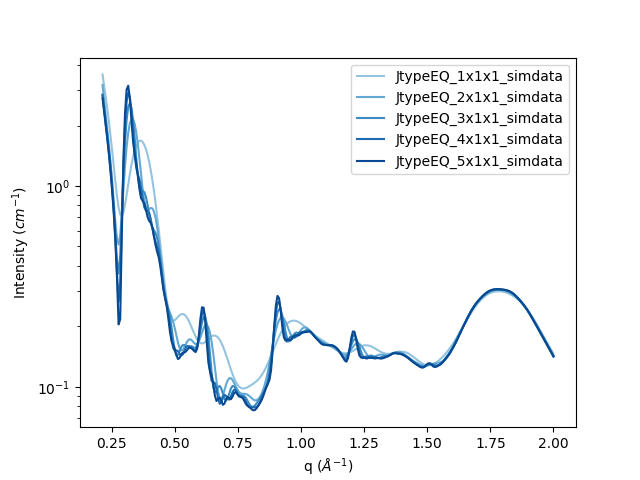

In [30]:
%matplotlib widget
fig, ax1 = subplots(1)
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/x_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*_simdata.txt'))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(files)))

a = 0.007
power = -4

for i, data_file in enumerate(files):
    name = os.path.basename(data_file)
    name_short = name[:-4]
    sim_data = np.loadtxt(data_file)
    sim_data[:,1][sim_data[:,0]<0.21]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    ax1.plot(sim_data[:,0], sim_data[:,1]-powerlaw_vals, label=name_short, color=colors[i])


# ax1.plot(sim_data[:,0], powerlaw_vals, label=name_short, color='black')

plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

/var/folders/t1/6t_6g7kx0c9dgv5ry3lmt2pr0000gp/T/ipykernel_7921/1173529291.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = subplots(1)


Text(0, 0.5, 'Intensity ($cm^{-1}$)')

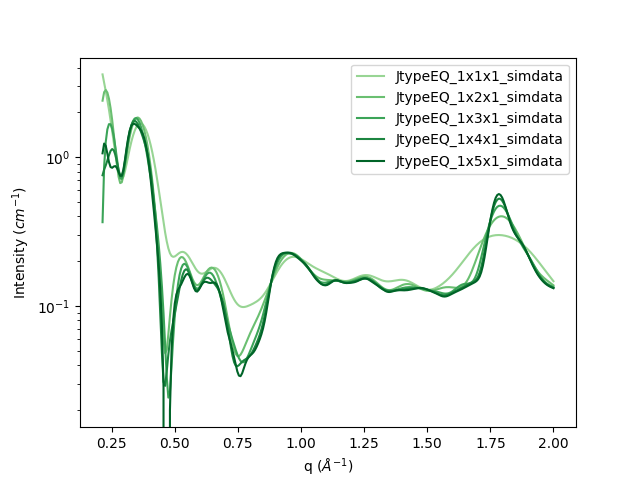

In [31]:
%matplotlib widget
fig, ax1 = subplots(1)
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/y_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*_simdata.txt'))
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(files)))

a = 0.007
power = -4

for i, data_file in enumerate(files):
    name = os.path.basename(data_file)
    name_short = name[:-4]
    sim_data = np.loadtxt(data_file)
    sim_data[:,1][sim_data[:,0]<0.21]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    ax1.plot(sim_data[:,0], sim_data[:,1]-powerlaw_vals, label=name_short, color=colors[i])


# ax1.plot(sim_data[:,0], powerlaw_vals, label=name_short, color='black')

plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

Text(0, 0.5, 'Intensity ($cm^{-1}$)')

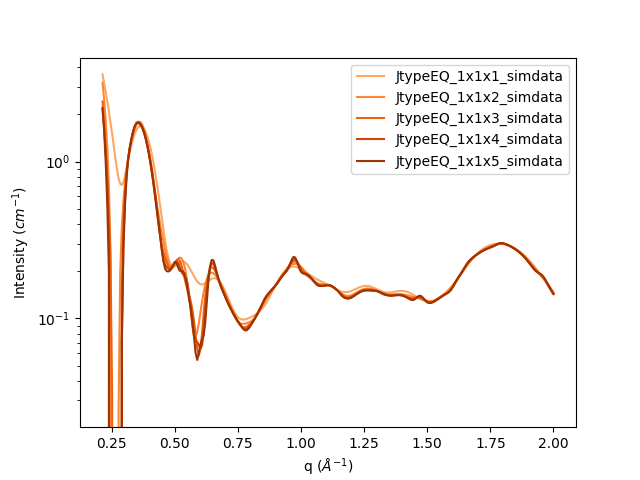

In [32]:
%matplotlib widget
fig, ax1 = subplots(1)
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/z_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*_simdata.txt'))
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(files)))

a = 0.007
power = -4

for i, data_file in enumerate(files):
    name = os.path.basename(data_file)
    name_short = name[:-4]
    sim_data = np.loadtxt(data_file)
    sim_data[:,1][sim_data[:,0]<0.21]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    ax1.plot(sim_data[:,0], sim_data[:,1]-powerlaw_vals, label=name_short, color=colors[i])


# ax1.plot(sim_data[:,0], powerlaw_vals, label=name_short, color='black')

plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

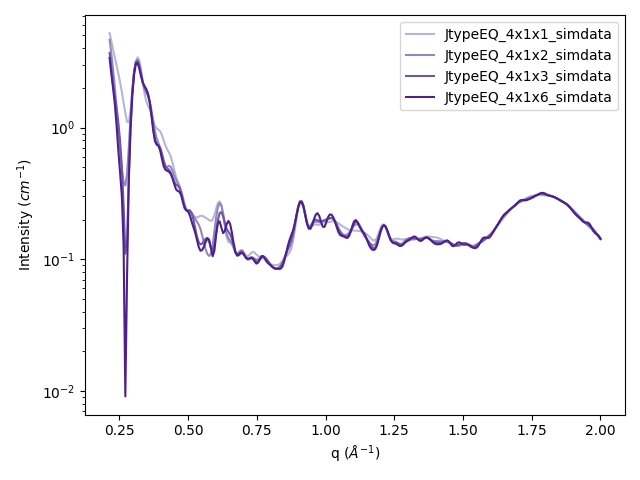

In [33]:
%matplotlib widget
fig, ax1 = subplots(1)
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/large_box_test/'
data_file = f'{dirr}JtypeEQ_4x1x2_simdata.txt'
files = sorted(glob.glob(f'{dirr}JtypeEQ_4x1x*simdata.txt'))

a = 0.002
power = -4

colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(files)))
for i, data_file in enumerate(files):
    name = os.path.basename(data_file)
    name_short = name[:-4]
    sim_data = np.loadtxt(data_file)
    sim_data[:,1][sim_data[:,0]<0.21]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    ax1.plot(sim_data[:,0], sim_data[:,1]-powerlaw_vals, label=name_short, color=colors[i])


# ax1.plot(sim_data[:,0], powerlaw_vals, label=name_short, color='black')

plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
plt.tight_layout()

In [ ]:
%%time
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
qs = np.linspace(0.1, 2, 300)
xyz_file = f'{dirr}JtypeEQ_4x1x2.xyz'
name = os.path.basename(xyz_file)
name_short = name[:-4]
Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
Jeq_total = np.vstack((qs, Jeq_sq_vals))
Jeq_total = np.transpose(Jeq_total)
np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

scatterer electron density=0.390032281607976, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

In [50]:
%%time
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
qs = np.linspace(0.1, 2, 300)
xyz_file = f'{dirr}HtypeEQ.xyz'
Heq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
Heq_total = np.vstack((qs, Heq_sq_vals))
Heq_total = np.transpose(Heq_total)

scatterer electron density=0.37082269978612226, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 16 s, sys: 71.2 ms, total: 16.1 s
Wall time: 16 s


In [6]:
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
xyz_path = f'{dirr}JtypeEQ.xyz'
# Extracting the atomic symbols and positions from the xyz file
with open(xyz_path, 'r') as file:
    lines = file.readlines()
# Extracting atom data
atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])
coords = np.array(coords)
x_max = np.max(coords[:,0])
y_max = np.max(coords[:,1])
z_max = np.max(coords[:,2])
x_min = np.min(coords[:,0])
y_min = np.min(coords[:,1])
z_min = np.min(coords[:,2])

In [7]:
print(x_max)
print(y_max)
print(z_max)

41.99
21.59
38.98


In [3]:
import glob
import os

Text(0, 0.5, 'Intensity ($cm^{-1}$)')

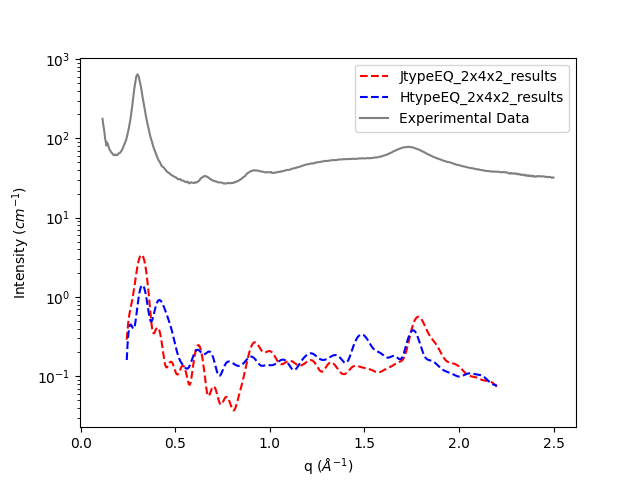

In [9]:
%matplotlib widget
fig, ax1 = subplots(1)
exp_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/'
exp_data = np.loadtxt(f'{exp_dirr}TC11_th0.15_05to85poscut.txt')
max_exp = np.nanmax(exp_data[:,1])


a = 0.002
power = -4
scale=1

sim_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/sim_data/'
for file in glob.glob(f'{sim_dirr}JtypeEQ_2x4x2*.txt'):
    name = os.path.basename(file)
    name_short = name.split('.')[0]
    sim_data = np.loadtxt(file)
    sim_data[:,1][sim_data[:,0]<0.24]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    # max_sim = np.nanmax(sim_data[:,1])
    ax1.plot(sim_data[:,0], (sim_data[:,1]-powerlaw_vals)*scale, label=name_short, color='red', linestyle='--')

sim_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/sim_data/'
for file in glob.glob(f'{sim_dirr}HtypeEQ_2x4x2*.txt'):
    name = os.path.basename(file)
    name_short = name.split('.')[0]
    sim_data = np.loadtxt(file)
    sim_data[:,1][sim_data[:,0]<0.24]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    # max_sim = np.nanmax(sim_data[:,1])
    ax1.plot(sim_data[:,0], (sim_data[:,1]-powerlaw_vals)*scale, label=name_short, color='blue', linestyle='--')



# ax1.plot(Jeq_total[:,0], (Jeq_total[:,1]-powerlaw_vals)*scale, label='Jeq_small', color='blue', linestyle='--')
ax1.plot(exp_data[:,0], exp_data[:,1], label='Experimental Data', color='gray')


# ax1.plot(Jeq_total[:,0], powerlaw_vals, label='power')
plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

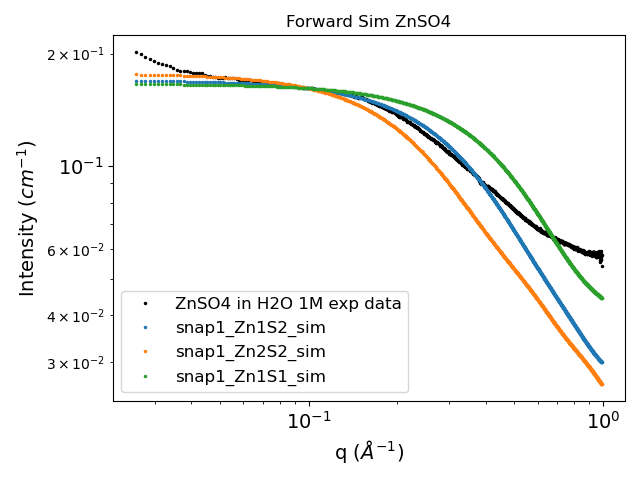

In [22]:
# exp_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/'
# exp_file = exp_dirr + 'SAXS_absolute_1M.csv'

exp_dirr = pathlib.Path('/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/')
exp_file = exp_dirr.joinpath('ZnSO4_1M_H2O.txt')

exp_data = np.loadtxt(exp_file)



# label_list = ['PbI6 + 0DMF', 'PbI5 + 1DMF', 'PbI4 + 2DMF', 'PbI3 + 3DMF', 'PbI2 + 4DMF']
# sq_list = [PbI6_f0_sq_vals, PbI5_f0_sq_vals, PbI4_f0_sq_vals, PbI3_f0_sq_vals, PbI2_f0_sq_vals]
fig, ax1 = subplots(1)
index = find_nearest_index(exp_data, 0.1)
ax1.plot(exp_data[:,0], exp_data[:,1], label ='ZnSO4 in H2O 1M exp data',
         color='black', linestyle='None', marker = '.', markersize=3)
sq1 = snap1_Zn1S2_sq_vals
norm = exp_data[index,1]/sq1[index]
ax1.plot(exp_data[:,0], (sq1*norm), label='snap1_Zn1S2_sim', linestyle='None', marker = '.', markersize=3)
sq2 = snap1_Zn2S2_sq_vals
norm = exp_data[index,1]/sq2[index]
ax1.plot(exp_data[:,0], (sq2*norm), label='snap1_Zn2S2_sim', linestyle='None', marker = '.', markersize=3)
sq3 = snap1_Zn1S1_sq_vals
norm = exp_data[index,1]/sq3[index]
ax1.plot(exp_data[:,0], (sq3*norm), label='snap1_Zn1S1_sim', linestyle='None', marker = '.', markersize=3)

ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
ax1.legend(prop={'size': 12})
ax1.set_title('Forward Sim ZnSO4')
plt.tight_layout()
# save_dir = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/pvsk_speciation/foward_sim_figs/'
# plt.savefig(save_dir + 'Pb_noSolvent_DMFBkg.png', dpi=300)
# plt.close('all')

[[Model]]
    Model(fitting_model_nopeak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 951
    # variables        = 2
    chi-square         = 0.00186368
    reduced chi-square = 1.9638e-06
    Akaike info crit   = -12494.7227
    Bayesian info crit = -12485.0077
    R-squared          = 0.99824287
[[Variables]]
    w1:   6.9729e-06 +/- 9.4964e-09 (0.14%) (init = 1)
    bkg:  0.03462641 +/- 8.6427e-05 (0.25%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(w1, bkg) = -0.8506


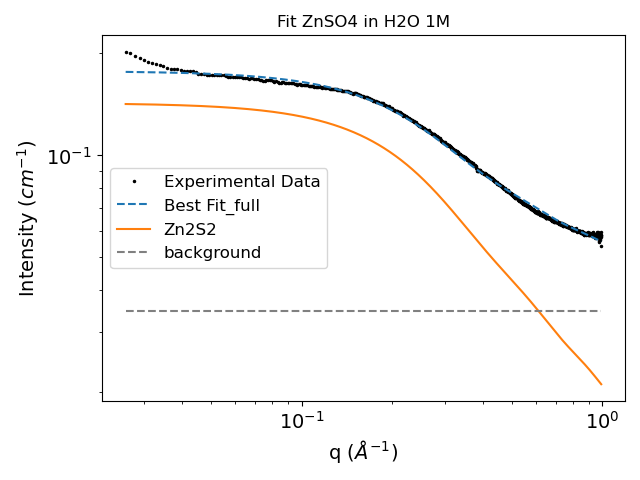

In [41]:
#fitting with selected curves
from lmfit import Model, Parameters

#experimental data
exp_dirr = pathlib.Path('/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/')
exp_file = exp_dirr.joinpath('ZnSO4_1M_H2O.txt')

exp_data = np.loadtxt(exp_file)

mask = (exp_data[:, 0] >= 0.07) & (exp_data[:, 0] <= 1.00)
# mask = (exp_data[:, 0] >= 0.01) & (exp_data[:, 0] <= 3.7)
filtered_data = exp_data[mask]
q_vals_exp = filtered_data[:,0]
int_vals_exp = filtered_data[:,1]
q_vals_exp_full = exp_data[:, 0]  # The full range of q values
int_vals_exp_full = exp_data[:, 1]  # The full range of q values
# q_vals_exp = exp_data[:,0]
# intensity_vals_exp = exp_data[:,1]

#modeled data (q_values must match experimental)
label_list = ['Zn2S2']
sq_list = [snap1_Zn2S2_sq_vals]
# label_list = ['Zn2S2', 'Zn1S2', 'Zn1S1']
# sq_list = [snap1_Zn2S2_sq_vals, snap1_Zn1S2_sq_vals, snap1_Zn1S1_sq_vals]

def fitting_model_nopeak(w1,bkg,sq1,q_vals,exp_data):
    sq_total = w1*sq1 + bkg
    index_min = find_nearest_index(exp_data, np.min(q_vals))
    index_max = find_nearest_index(exp_data, np.max(q_vals))
    return sq_total[index_min:index_max+1]
# def fitting_model_nopeak(w1,w2,w3,bkg,sq1,sq2,sq3,q_vals,exp_data):
#     sq_total = w1*sq1 + w2*sq2 + w3*sq3 + bkg
#     index_min = find_nearest_index(exp_data, np.min(q_vals))
#     index_max = find_nearest_index(exp_data, np.max(q_vals))
#     return sq_total[index_min:index_max+1]
    
# Create a model object
model = Model(fitting_model_nopeak, independent_vars=['q_vals', 'exp_data', 'sq1'])
# model = Model(fitting_model_nopeak, independent_vars=['q_vals', 'exp_data', 'sq1', 'sq2', 'sq3'])

# Set initial parameter values
params = Parameters()
params.add('w1', value=1, min=0)
# params.add('w2', value=1, min=0)
# params.add('w3', value=1, min=0)
params.add('bkg', value=5e-2, min=0)

# Perform the fit
result = model.fit(int_vals_exp, params, q_vals=q_vals_exp, exp_data=exp_data, sq1=sq_list[0])

#plot results
best_fit_full = fitting_model_nopeak(**result.params, sq1=sq_list[0], q_vals=q_vals_exp_full, exp_data=exp_data)

# # Perform the fit
# result = model.fit(int_vals_exp, params, q_vals=q_vals_exp, exp_data=exp_data, sq1=sq_list[0], sq2=sq_list[1], sq3=sq_list[2])

# #plot results
# best_fit_full = fitting_model_nopeak(**result.params, sq1=sq_list[0], sq2=sq_list[1], sq3=sq_list[2], q_vals=q_vals_exp_full, exp_data=exp_data)


fig, ax1 = subplots(1)
ax1.plot(q_vals_exp_full, int_vals_exp_full, linestyle='None', marker='.',markersize=3, color='black', label='Experimental Data')
ax1.plot(q_vals_exp_full, best_fit_full, linestyle='--', label='Best Fit_full')
for i, sq in enumerate(sq_list):
    weight = result.params[f'w{i+1}'].value
    ax1.plot(exp_data[:,0], sq*weight, label=label_list[i])
ax1.plot(exp_data[:,0], np.full_like(exp_data[:,0],result.params['bkg'].value), label='background', color='grey', linestyle='--')

ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_ylim(5e-3,0.2)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
ax1.legend(prop={'size': 12})
ax1.set_title('Fit ZnSO4 in H2O 1M')
plt.tight_layout()


# Print the fit results
print(result.fit_report())

In [40]:
result.params['bkg'].value

0.034626413733789274

scatterer electron density=1.17556630264619, solvent electron density=0.0
0 atoms were found to have electron density less than solvent. No scatterers populated for [' ']
scatterer electron density=1.17556630264619, solvent electron density=0.25
0 atoms were found to have electron density less than solvent. No scatterers populated for [' ']
scatterer electron density=1.17556630264619, solvent electron density=0.5
30 atoms were found to have electron density less than solvent. No scatterers populated for [' ', 'C', 'N', 'O']
scatterer electron density=1.17556630264619, solvent electron density=0.75
30 atoms were found to have electron density less than solvent. No scatterers populated for [' ', 'C', 'N', 'O']
scatterer electron density=1.17556630264619, solvent electron density=1.0
30 atoms were found to have electron density less than solvent. No scatterers populated for [' ', 'C', 'N', 'O']


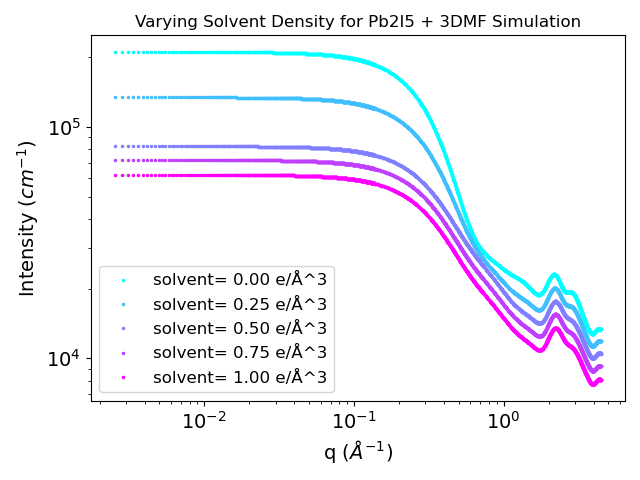

In [242]:
#effect of solvent density
exp_file = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/pvsk_speciation/Perovskite_SAXS/subtracted_new/PbI2_DMF_MolaritySeries2/PbI2_DMF_0p5M_sol398_buf389_emp337.txt'
xyz_file = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/pvsk_speciation/Pb_solvate_structure_generator/corner_solvbl3/corner_2Pb_3SolvperPb_45dihedral.xyz'
exp_data = np.loadtxt(exp_file)

edensities = np.linspace(0,1,num=5)

fig, ax1 = subplots(1)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.cool(np.linspace(0, 1, len(edensities)))))
for edens in edensities:
    PbI3_sq_vals = xyz_simulation(xyz_file, exp_file,  edens, plot_hull=False)
    ax1.plot(exp_data[:,0], PbI3_sq_vals, label =f'solvent= {edens:.2f} e/Å^3', linestyle='None', marker = '.', markersize=3)
    
    
    
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
ax1.legend(prop={'size': 12})
ax1.set_title('Varying Solvent Density for Pb2I5 + 3DMF Simulation')
plt.tight_layout()
plt.savefig(save_dir + 'solvent_dens_Pb2I5.png', dpi=300)